### 一、项目背景
为识别影响用户留存的关键行为路径与指标，构建评分模型辅助产品决策，提升用户体验与用户质量识别效率
### 二、数据局限
本来项目的标题是"确定关键行为+渠道质量打分"

而原始数据包含："key_action.xlsx"，"revenue_ability_data.csv"，"权重打分表"，"score_data.xlsx"，但是revenue文件少了渠道的关键字，权重打分表人为影响因素较大，score_data明显是产出结果，所以暂时分析关键行为+评分模型

In [209]:
# 导入常用库
import pandas as pd                      # 数据处理主力军
import numpy as np                       # 数学计算 + 缺失值处理
import matplotlib.pyplot as plt          # 可视化
import seaborn as sns                    # 更美观的可视化

# 设置图表风格
sns.set(style="whitegrid")               # 让图表背景更清爽
plt.rcParams['font.size'] = 12           # 设置默认字体大小
plt.rcParams['figure.figsize'] = (10, 6) # 设置图表默认大小

# 设置 Pandas 显示参数
pd.set_option('display.max_columns', 100)       # 最多显示 100 列（避免列被省略）
pd.set_option('display.max_rows', 100)          # 最多显示 100 行（避免行被省略）
pd.set_option('display.max_colwidth', 200)      # 每列最多显示 200 个字符（防止文本被截断）
pd.set_option('display.float_format', '{:.4f}'.format) 

In [177]:
# 设置支持中文的字体（如微软雅黑、SimHei等）
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


### 识别关键指标

In [178]:
df_key = pd.read_excel('key_action.xlsx')
df_key.head()

,key_action,key_action_cnt,retention_rate
0,收藏,1,0.0020
1,收藏,2,0.0250
2,收藏,3,0.0270
3,收藏,4,0.0290
4,收藏,5,0.1500


In [179]:
df_key['key_action'].unique().tolist()

['收藏', '分享', '更换模板', '消息互动']

In [180]:
collection_cnt = df_key[df_key['key_action'] == '收藏']
share_cnt = df_key[df_key['key_action'] == '分享']
template_cnt = df_key[df_key['key_action'] == '更换模板']
message_cnt = df_key[df_key['key_action'] == '消息互动']

In [181]:
corr1 = collection_cnt[['key_action_cnt','retention_rate']].corr()
print(corr1)

                key_action_cnt  retention_rate
key_action_cnt          1.0000          0.8145
retention_rate          0.8145          1.0000


In [182]:
corr2 = share_cnt[['key_action_cnt','retention_rate']].corr()
print(corr2)

                key_action_cnt  retention_rate
key_action_cnt          1.0000          0.9266
retention_rate          0.9266          1.0000


In [183]:
corr3 = template_cnt[['key_action_cnt','retention_rate']].corr()
print(corr3)

                key_action_cnt  retention_rate
key_action_cnt          1.0000          0.8597
retention_rate          0.8597          1.0000


In [184]:
corr4 = message_cnt[['key_action_cnt','retention_rate']].corr()
print(corr4)

                key_action_cnt  retention_rate
key_action_cnt          1.0000          0.5396
retention_rate          0.5396          1.0000


In [185]:
# corr>0.8 与留存率相关性较大的指标：收藏、分享、更换模板
key_action = ['收藏', '分享', '更换模板']

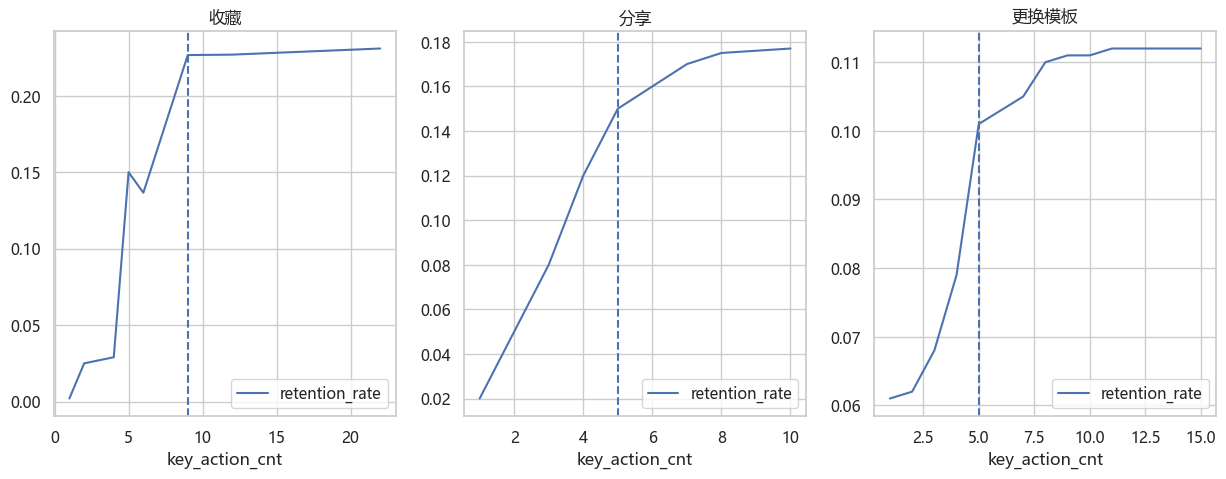

In [186]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i, key in enumerate(key_action):
    df_plot = df_key[df_key['key_action'] == key]
    df_plot.plot(kind='line',x='key_action_cnt',y='retention_rate',ax=ax[i],title=key)

ax[0].axvline(x=9,ls='--')
ax[1].axvline(x=5,ls='--')
ax[2].axvline(x=5,ls='--')

### 确定关键行为标准
收藏数为9，分享数为5，更换模板数为5这些是留存的拐点

## 层次分析法
由于原有资料的权重打分表不确定评判标准，虽然它符合AHP的判断矩阵：  
对角线都是 1  
成对互反关系（A vs B = 2，B vs A = 0.5）  
值分布合理（1/5 到 5 的区间）  
最终执行了一致性检验 CR < 0.1

但是它的使用时长占权重最高，而广告展示次数最具相关性，和真实业务略有差异，并没有考虑到启动次数多、广告也多的情况

所以此处使用数据驱动+回归分析确定相关性矩阵

### ❌原权重打分表分析

In [187]:
df_score = pd.read_excel('权重打分表.xlsx',index_col='Z')
df_score

,launch_cnt,PV,ad_show_cnt,duration
Z,,,,
launch_cnt,1,0.5000,0.3333,0.2000
PV,2,1.0000,0.5000,0.2500
ad_show_cnt,3,2.0000,1.0000,0.3333
duration,5,4.0000,3.0000,1.0000


In [188]:
# 特征向量法得出权重
# def函数直接ai出，只需要知道这个方法能科学求出权重就行）
def eigenvector_ahp(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_idx = np.argmax(eigenvalues)
    weights = eigenvectors[:, max_idx].real
    weights = weights / weights.sum()  # 归一化
    return weights

weights = eigenvector_ahp(df_score)
print("特征向量法权重:", weights)

特征向量法权重: [0.08375196 0.13772546 0.23229999 0.54622259]


In [189]:
# 计算一致性比率CR
def calculate_cr(matrix, weights):
    n = matrix.shape[0]
    # 计算最大特征值 λ_max
    weighted_sum = np.dot(matrix, weights)
    lambda_max = np.mean(weighted_sum / weights)
    # 计算CI和CR
    CI = (lambda_max - n) / (n - 1)
    RI = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45}[n] 
    CR = CI / RI
    return CR

CR = calculate_cr(df_score.values, weights)
print("一致性比率 CR:", round(CR, 3))
if CR < 0.1:
    print("结论：CR < 0.1，一致性可接受")
else:
    print("警告：CR ≥ 0.1，需调整判断矩阵！")

一致性比率 CR: 0.019
结论：CR < 0.1，一致性可接受


不需要上述两个函数的由来，在这里知道这样可以求出权重和判断逻辑性（CR<0.1，若CR超标， 
会出现A>B,B>C 但C>A的逻辑错误）

## 回归求逻辑性打分表
从原始数据导出数据求权重打分表，而非人为打分

In [190]:
df_revenue = pd.read_csv('revenue_ability_data.csv',index_col='Unnamed: 0')
df_revenue.columns.to_list()

['user_id', 'launch_cnt', 'PV', 'ad_show_cnt', 'duration']

In [191]:
df = df_revenue[['launch_cnt', 'PV', 'ad_show_cnt', 'duration']]
df.head()

,launch_cnt,PV,ad_show_cnt,duration
0,2,0,1,3056
1,2,0,4,0
2,2,0,3,0
3,5,15,5,312980
4,11,1,18,127880


In [192]:
# 计算相关性矩阵
corr_matrix = df.corr()
print(corr_matrix)

# relevance_score是相关指标在整个系统中的相关性总和
relevance_score = corr_matrix.sum(axis=1)
relevance_score

             launch_cnt      PV  ad_show_cnt  duration
launch_cnt       1.0000  0.0124       0.4617   -0.0040
PV               0.0124  1.0000       0.2025   -0.0008
ad_show_cnt      0.4617  0.2025       1.0000   -0.0074
duration        -0.0040 -0.0008      -0.0074    1.0000


launch_cnt    1.4701
PV            1.2141
ad_show_cnt   1.6567
duration      0.9877
dtype: float64

In [193]:
# 构建判断矩阵（两两相除后的结论可以判断A相比B是否与整个系统更强相关）
features = df.columns.to_list()
ahp_matrix = pd.DataFrame(index=features, columns=features)
for i in features:
    for j in features:
        ahp_matrix.loc[i, j] = relevance_score[i] / relevance_score[j]

ahp_matrix = ahp_matrix.astype(float)
ahp_matrix

,launch_cnt,PV,ad_show_cnt,duration
launch_cnt,1.0000,1.2108,0.8874,1.4884
PV,0.8259,1.0000,0.7328,1.2292
ad_show_cnt,1.1269,1.3646,1.0000,1.6773
duration,0.6719,0.8135,0.5962,1.0000


In [198]:
# 列归一化 → 行平均计算权重
normalized_matrix = ahp_matrix.apply(lambda col: col / col.sum(), axis=0)
normalized_matrix["row_sum"] = normalized_matrix.sum(axis=1)
normalized_matrix["weight"] = normalized_matrix["row_sum"] / normalized_matrix["row_sum"].sum()
weights = normalized_matrix["weight"]
weights

launch_cnt    0.2759
PV            0.2278
ad_show_cnt   0.3109
duration      0.1854
Name: weight, dtype: float64

AHP中，launch_cnt列代表其他因素对	launch_cnt的打分，但是每个因素的相关性矩阵经过判断矩阵的相除是受到影响的，所以每一行给出的分数打分尺度不一样

所以要将被评价者的分数归一化才能互相比较，得出权重，只能采用列归一化→行求均值的权重推导方式

<span style="color:red">这个真的很绕，其实我对由相关性矩阵一直求出权重持怀疑态度，主要就是归一化后的行总和再归一化略带疑惑，不过先按这个通用逻辑写</span>

In [ ]:
# 一致性检验
def calculate_cr(matrix, weights):
    weights = weights.values.reshape(-1, 1) 
    n = matrix.shape[0]
    weighted_sum = np.dot(matrix, weights)
    lambda_max = np.mean(weighted_sum / weights)
    CI = (lambda_max - n) / (n - 1)
    RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45}
    RI = RI_dict.get(n, 1.49)  # 默认给一个值避免 key error
    CR = CI / RI
    return CR

CR = calculate_cr(ahp_matrix.values, weights)
if CR < 0.1:
    print("✅ 一致性通过，权重结果可信")
else:
    print("❌ 一致性未通过，请重新构造判断矩阵")

✅ 一致性通过，权重结果可信


所以以通过相关性矩阵构造出来的为权重打分表